In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

file_url = 'https://raw.githubusercontent.com/YufanPeter/EPL_Analysis/refs/heads/main/EPL_fyp.csv'
df = pd.read_csv(file_url)

In [2]:
# Check if each match has a complementary record (home vs away and vice versa)
def has_complementary_record(row, df):
    if row['Venue'] == 'Away':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Home')
        ]
    elif row['Venue'] == 'Home':
        match = df[
            (df['Season'] == row['Season']) &
            (df['Team'] == row['Opponent']) &
            (df['Opponent'] == row['Team']) &
            (df['Venue'] == 'Away')
        ]
    else:
        return False

    return not match.empty

df['has_match'] = df.apply(lambda row: has_complementary_record(row, df), axis=1)

if df['has_match'].all():
    print("All matched!")
else:
    missing_matches = df[~df['has_match']]
    print("Lack of data")
    print(missing_matches)

All matched!


In [3]:
# Match each home game with its corresponding away game
# Ensure each pair is officiated by the same referee
df_home = df[(df['Venue'] == 'Home') & (df['has_match'])].copy()
df_away = df[(df['Venue'] == 'Away') & (df['has_match'])].copy()

matched_pairs = []
used_away = set()

for home_index, home_row in df_home.iterrows():
    away = df_away[
        (df_away['Season'] == home_row['Season']) &
        (df_away['Team'] == home_row['Opponent']) &
        (df_away['Opponent'] == home_row['Team']) &
        (~df_away.index.isin(used_away))
    ]

    if not away.empty:
        away_index = away.index[0]
        matched_pairs.append((home_index, away_index))
        used_away.add(away_index)

count = 0
for home_idx, away_idx in matched_pairs:
    home_referee = df.loc[home_idx, 'Referee']
    away_referee = df.loc[away_idx, 'Referee']
    if home_referee == away_referee:
        count += 1

print("Number of matched pairs with the same referee:", count)

Number of matched pairs with the same referee: 3800


In [5]:
# Construct a match-level dataset by extracting and calculating key features (e.g., fouls, cards, xG, extra time)
# from matched pairs. Each match is represented twice (home and away) for symmetry in analysis.
from scipy.stats import zscore
import numpy as np
import pandas as pd

big6 = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester City',
        'Manchester United', 'Tottenham Hotspur']

team_records = []

def compute_ratio(fouls, cards):
    return round(fouls / cards, 2) if cards != 0 else np.nan

for (idx1, idx2) in matched_pairs:
    rec1 = df.loc[idx1].copy()
    rec2 = df.loc[idx2].copy()

    if rec1['Venue'] != 'Home':
        rec1, rec2 = rec2, rec1

    referee = rec1['Referee']
    season = rec1['Season']

    if rec1['Result'] == 'W':
        is_win = 1
    elif rec1['Result'] == 'L':
        is_win = -1
    else:
        is_win = 0

    home_cards = rec1['CrdY'] + rec1['2CrdY'] + rec1['CrdR']
    away_cards = rec2['CrdY'] + rec2['2CrdY'] + rec2['CrdR']
    diff_cards = home_cards - away_cards

    home_fls = rec1['Fls (fouls committed)']
    away_fls = rec2['Fls (fouls committed)']
    diff_fls = home_fls - away_fls

    home_ratio = compute_ratio(home_fls, home_cards)
    away_ratio = compute_ratio(away_fls, away_cards)
    diff_ratio = home_ratio - away_ratio if pd.notnull(home_ratio) and pd.notnull(away_ratio) else np.nan

    home_xg = rec1.get('xG (expected goals)', np.nan)
    away_xg = rec2.get('xG (expected goals)', np.nan)
    diff_xG = home_xg - away_xg if pd.notnull(home_xg) and pd.notnull(away_xg) else np.nan

    extra_time = rec1['Second Extra Time']

    team_records.append({
        'Referee': referee,
        'Season': season,
        'Team': rec1['Team'],
        'is_win': is_win,
        'Goals': rec1['GF (goals for)'],
        'Fouls': home_fls,
        'Yellow Cards': rec1['CrdY'] + rec1['2CrdY'],
        'Red Cards': rec1['CrdR'],
        'diff_goal': rec1['GF (goals for)'] - rec2['GF (goals for)'],
        'diff_cards': diff_cards,
        'diff_fls': diff_fls,
        'diff_ratio': diff_ratio,
        'diff_xG': diff_xG,
        'extra_time': extra_time,
        'Team Region': rec1['Team Detailed Region'],
        'Referee Hometown': rec1['Referee Hometown'],
        'is_home': 1
    })

    team_records.append({
        'Referee': referee,
        'Season': season,
        'Team': rec2['Team'],
        'is_win': -is_win,
        'Goals': rec2['GF (goals for)'],
        'Fouls': away_fls,
        'Yellow Cards': rec2['CrdY'] + rec2['2CrdY'],
        'Red Cards': rec2['CrdR'],
        'diff_goal': rec2['GF (goals for)'] - rec1['GF (goals for)'],
        'diff_cards': -diff_cards if pd.notnull(diff_cards) else np.nan,
        'diff_fls': -diff_fls if pd.notnull(diff_fls) else np.nan,
        'diff_ratio': -diff_ratio if pd.notnull(diff_ratio) else np.nan,
        'diff_xG': -diff_xG if pd.notnull(diff_xG) else np.nan,
        'extra_time': extra_time,
        'Team Region': rec2['Team Detailed Region'],
        'Referee Hometown': rec2['Referee Hometown'],
        'is_home': 0
    })

match_df = pd.DataFrame(team_records)

In [6]:
# Add binary indicators for Club Reputation and Referee Hometown:
# 'rep' = 1 if the team is in the Big Six; 'is_hometown' = 1 if the team region matches the referee's hometown.
match_df['rep'] = match_df['Team'].apply(lambda x: 1 if x in big6 else 0)
match_df['is_hometown'] = (match_df['Team Region'] == match_df['Referee Hometown']).astype(int)
print(match_df.columns)

Index(['Referee', 'Season', 'Team', 'is_win', 'Goals', 'Fouls', 'Yellow Cards',
       'Red Cards', 'diff_goal', 'diff_cards', 'diff_fls', 'diff_ratio',
       'diff_xG', 'extra_time', 'Team Region', 'Referee Hometown', 'is_home',
       'rep', 'is_hometown'],
      dtype='object')


In [9]:
# Construct weakly-supervised bias labels based on match statistics using quantile thresholds and weighted scoring.
# Features are normalized, binarized by thresholds, then combined into a composite bias score.
# Matches with higher scores are labeled as biased (1), otherwise unbiased (0).
from scipy.stats import zscore

cols_for_z = ['diff_cards', 'diff_fls', 'diff_ratio', 'diff_xG', 'extra_time']
for col in cols_for_z:
    match_df[col] = match_df[col].fillna(match_df[col].mean())

match_df['z_diff_cards'] = zscore(-match_df['diff_cards'])
match_df['z_diff_fls']   = zscore(-match_df['diff_fls'])
match_df['z_diff_xG']    = zscore(match_df['diff_xG'])
match_df['z_diff_ratio'] = zscore(match_df['diff_ratio'])

diff_xG_med, diff_xG_q75 = match_df['diff_xG'].median(), match_df['diff_xG'].quantile(0.75)
diff_cards_med, diff_cards_q25 = match_df['diff_cards'].median(), match_df['diff_cards'].quantile(0.25)
diff_fls_med, diff_fls_q25 = match_df['diff_fls'].median(), match_df['diff_fls'].quantile(0.25)
diff_ratio_med, diff_ratio_q75 = match_df['diff_ratio'].median(), match_df['diff_ratio'].quantile(0.75)

match_df['bias_diff_xG']    = (match_df['diff_xG'] > diff_xG_q75).astype(int)
match_df['bias_diff_cards'] = (match_df['diff_cards'] < diff_cards_q25).astype(int)
match_df['bias_diff_fls']   = (match_df['diff_fls'] < diff_fls_q25).astype(int)
match_df['bias_diff_ratio'] = (match_df['diff_ratio'] < diff_ratio_q75).astype(int)

weights = {
    'bias_diff_xG': 0.2,
    'bias_diff_cards': 0.15,
    'bias_diff_fls': 0.1,
    'bias_diff_ratio': 0.15,
    'is_home': 0.2,
    'rep': 0.1,
    'is_hometown': 0.1
}

match_df['weighted_bias_score'] = (
    weights['bias_diff_xG'] * match_df['bias_diff_xG'] +
    weights['bias_diff_cards'] * match_df['bias_diff_cards'] +
    weights['bias_diff_fls'] * match_df['bias_diff_fls'] +
    weights['bias_diff_ratio'] * match_df['bias_diff_ratio'] +
    weights['is_home'] * (match_df['is_home'] == 1).astype(int) +
    weights['rep'] * (match_df['rep'] == 1).astype(int) +
    weights['is_hometown'] * (match_df['is_hometown'] == 1).astype(int)
)

max_score = sum(weights.values())
match_df['match_bias_label_weighted'] = (match_df['weighted_bias_score'] >= 0.5 * max_score).astype(int)

print(match_df[['Team', 'weighted_bias_score', 'match_bias_label_weighted']].head())

               Team  weighted_bias_score  match_bias_label_weighted
0   Manchester City                 0.65                          1
1  Newcastle United                 0.15                          0
2   Manchester City                 0.65                          1
3            Fulham                 0.15                          0
4   Manchester City                 0.80                          1


In [10]:
# Label distribution
print(match_df['match_bias_label_weighted'].value_counts(normalize=True))

match_bias_label_weighted
0    0.779342
1    0.220658
Name: proportion, dtype: float64


In [12]:
# Train a binary classification MLP to predict referee bias labels using match statistics.
# Includes data scaling, class balancing, early stopping, and L2 regularization for stability.
from tensorflow.keras import regularizers
from sklearn.utils import class_weight

model_features = ['Yellow Cards', 'Red Cards', 'Fouls', 'diff_goal']
X = match_df[model_features]
y = match_df['match_bias_label_weighted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Computed class weights:", class_weights_dict)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stop],class_weight=class_weights_dict)

Computed class weights: {0: np.float64(0.6416209371042634), 1: np.float64(2.2652757078986587)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5112 - loss: 0.7981 - val_accuracy: 0.6661 - val_loss: 0.7144
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6811 - loss: 0.7070 - val_accuracy: 0.6538 - val_loss: 0.6980
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6682 - loss: 0.6876 - val_accuracy: 0.6521 - val_loss: 0.6886
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6664 - loss: 0.6732 - val_accuracy: 0.6390 - val_loss: 0.6953
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6573 - loss: 0.6805 - val_accuracy: 0.6546 - val_loss: 0.6576
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6715 - loss: 0.6663 - val_accuracy: 0.6480 - val_loss: 0.6672
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6673 - loss: 0.6529 - val_accuracy: 0.6406 - val_loss: 0.6623
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6796 - loss: 0.6370 - val_accu

In [13]:
# Evaluation Performance
from sklearn.metrics import classification_report, roc_auc_score

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print('AUC score:', roc_auc_score(y_test, y_pred_prob))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1185
           1       0.41      0.69      0.51       335

    accuracy                           0.71      1520
   macro avg       0.65      0.70      0.65      1520
weighted avg       0.78      0.71      0.73      1520

AUC score: 0.7668984192959255


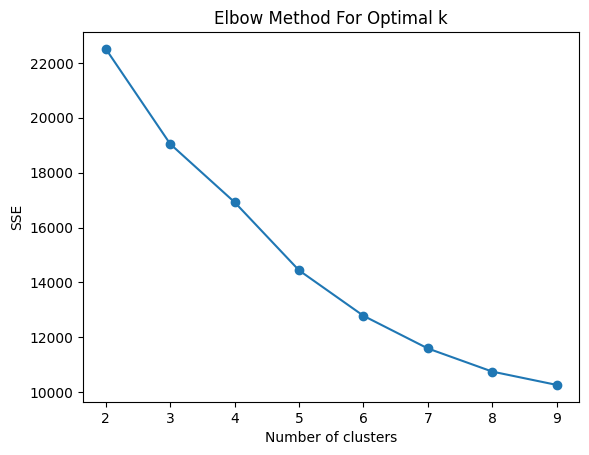

In [14]:
# Apply Elbow Method to determine the optimal number of clusters for KMeans based on match-level features.
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

features = ['diff_xG', 'diff_cards', 'diff_fls', 'diff_ratio']

for col in features:
    match_df[col] = match_df[col].fillna(match_df[col].mean())

scaler = StandardScaler()
X_unsup = scaler.fit_transform(match_df[features])

sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unsup)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

cluster
1    3944
0    3656
Name: count, dtype: int64


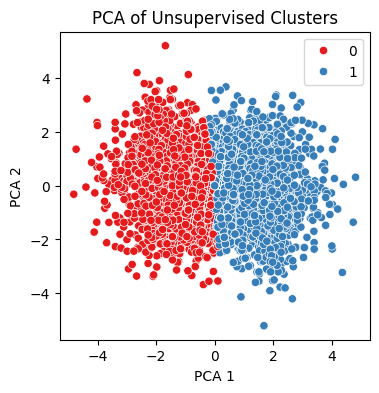

          diff_xG  diff_cards  diff_fls  diff_ratio
cluster                                            
0        0.400821   -1.426149 -1.018326    2.429978
1       -0.371552    1.322008  0.943966   -2.252535


In [27]:
# Perform KMeans clustering (k=2), then visualize clusters using PCA, and analyze average feature values per cluster.
import seaborn as sns
from sklearn.decomposition import PCA

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_unsup)
match_df['cluster'] = clusters

print(match_df['cluster'].value_counts())

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_unsup)

plt.figure(figsize=(4,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set1')
plt.title("PCA of Unsupervised Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

cluster_stats = match_df.groupby('cluster')[features].mean()
print(cluster_stats)

In [24]:
# This block trains a deep learning classification model (MLP) to predict match-level referee bias
# using features such as yellow/red cards, fouls, team reputation, and referee-team affiliations.
# The target label is derived from unsupervised K-means clustering (i.e., bias = cluster 0 or 1).
# It includes standardization, regularization, dropout, early stopping, and validation monitoring.
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model_features = ['Yellow Cards', 'Red Cards', 'Fouls', 'rep', 'is_home', 'is_hometown']
X = match_df[model_features]
y = match_df['cluster']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5989 - loss: 0.7938 - val_accuracy: 0.7316 - val_loss: 0.6671
Epoch 2/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7032 - loss: 0.6939 - val_accuracy: 0.7349 - val_loss: 0.6423
Epoch 3/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7091 - loss: 0.6754 - val_accuracy: 0.7329 - val_loss: 0.6290
Epoch 4/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7128 - loss: 0.6632 - val_accuracy: 0.7316 - val_loss: 0.6177
Epoch 5/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6964 - loss: 0.6587 - val_accuracy: 0.7270 - val_loss: 0.6069
Epoch 6/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7149 - loss: 0.6304 - val_accuracy: 0.7211 - val_loss: 0.6003
Epoch 7/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7147 - loss: 0.6249 - val_accuracy: 0.7263 - val_loss: 0.5954
Epoch 8/100
285/285 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7185 - loss: 0.6106 - val_accuracy: 0.7250

In [25]:
# It computes the test accuracy and loss, generates predicted probabilities,
# and reports classification metrics including precision, recall, F1-score, and AUC.
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

loss, acc = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Accuracy: {acc:.4f} | Loss: {loss:.4f}")

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7496 - loss: 0.5213

Test Accuracy: 0.7520 | Loss: 0.5232
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       731
           1       0.76      0.77      0.76       789

    accuracy                           0.75      1520
   macro avg       0.75      0.75      0.75      1520
weighted avg       0.75      0.75      0.75      1520

AUC Score: 0.8277105342092624


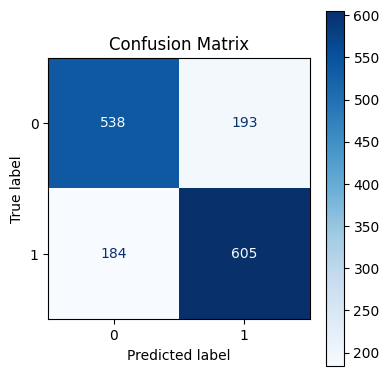

In [31]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

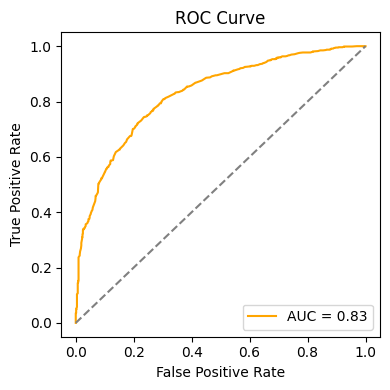

In [32]:
# Display the AUC score, indicating discriminatory ability
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, color='orange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()